In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, f1_score
from sklearn.calibration import calibration_curve

from fairlearn.metrics import true_positive_rate, true_negative_rate
import matplotlib.pyplot as plt

Make sure to run `data_introduction.ipynb` before running the cell below!

In [2]:
X_train = pd.read_pickle('cleaned_data/X_train.pickle')
y_train = pd.read_pickle('cleaned_data/y_train.pickle')
X_val = pd.read_pickle('cleaned_data/X_test.pickle')
y_val = pd.read_pickle('cleaned_data/y_test.pickle')
X_test = pd.read_pickle('cleaned_data/X_test.pickle')
y_test = pd.read_pickle('cleaned_data/y_test.pickle')

## Training final model
During this training we will use decision threshold optimization based on the roc curve.

In [3]:
# plot the confusion matrix for 50 features
k_best = SelectKBest(k=50)
k_best.fit(X_train, y_train)
X_train_selected = k_best.transform(X_train)
selected_features = X_train.columns[k_best.get_support()]

# train model with 50 features including 
log_reg = LogisticRegression(penalty='l2', solver='newton-cholesky')
log_reg.fit(X_train_selected, y_train)

LogisticRegression(solver='newton-cholesky')

Best Threshold=0.077221, G-Mean=0.782


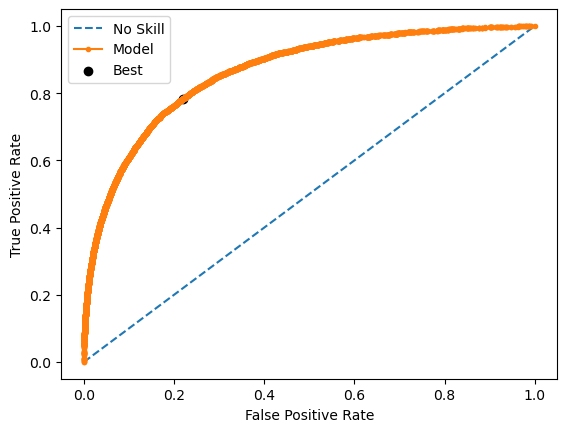

In [4]:
ax = plt.gca()
# keep probabilities for the positive outcome only
yhat = log_reg.predict_proba(X_train_selected)[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# calculate the g-mean for each threshold
gmeans = (tpr * (1-fpr))**0.5
# locate the index of the largest g-mean
ix = gmeans.argmax()
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
roc_plot = ax.plot([0,1], [0,1], linestyle='--', label='No Skill')
ax.plot(fpr, tpr, marker='.', label='Model')
ax.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend();

In [5]:
selected_threshold = thresholds[ix]   # this might still be changed

In [6]:
if 'ethnicity' in str(selected_features):
    print("ethnicity (the sensitive group) is in the selected features")
else:
    print("ethnicity (the sensitive group) is not in the selected features")

ethnicity (the sensitive group) is not in the selected features


## Performance metrics on test set

In [7]:
# do the test predictions
X_test_selected = k_best.transform(X_test)
y_pred_test = log_reg.predict_proba(X_test_selected)
y_pred_test_binary = (y_pred_test[:,1] >= selected_threshold).astype(int)

In [8]:
# metrics
print('Accuracy: ', accuracy_score(y_test, y_pred_test_binary))
print("TPR: %.3f" % true_positive_rate(y_test, y_pred_test_binary))
print("TNR: %.3f" % true_negative_rate(y_test, y_pred_test_binary))
print("FPR: %.3f" % (1 - true_negative_rate(y_test, y_pred_test_binary)))
print("FNR: %.3f" % (1 - true_positive_rate(y_test, y_pred_test_binary)))
print("F1 score: %.3f" % f1_score(y_test, y_pred_test_binary))
print("ROC-AUC score: %.3f" % roc_auc_score(y_test, y_pred_test_binary))

Accuracy:  0.7830353249018752
TPR: 0.781
TNR: 0.783
FPR: 0.217
FNR: 0.219
F1 score: 0.383
ROC-AUC score: 0.782


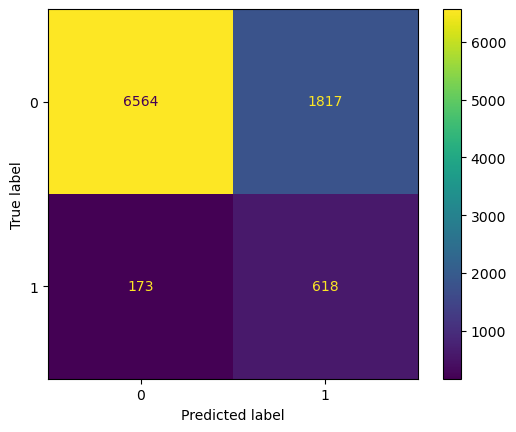

In [9]:
# confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred_test_binary)
ConfusionMatrixDisplay(confusion_matrix).plot();

### Calibration plot (using test set)

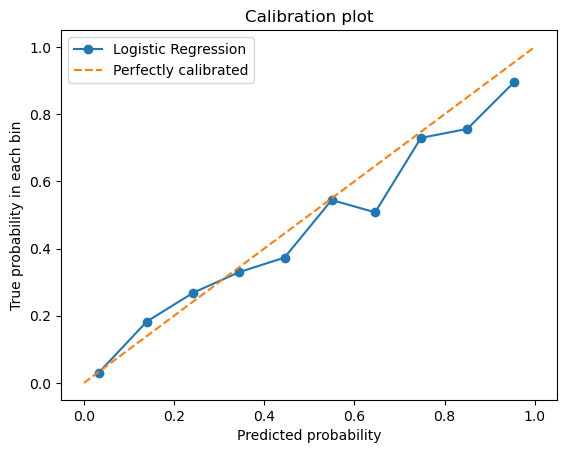

In [10]:
# make a calibiration plot of the model
prob_true, prob_pred = calibration_curve(y_test, y_pred_test[:,1], n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.title('Calibration plot')
plt.legend()
plt.show()